The code is showing how to fine-tuning pre-trained model with your own target.

In [1]:
import numpy as np
import torch
from torch import nn
import json
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments, Trainer, AdamW, EarlyStoppingCallback
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


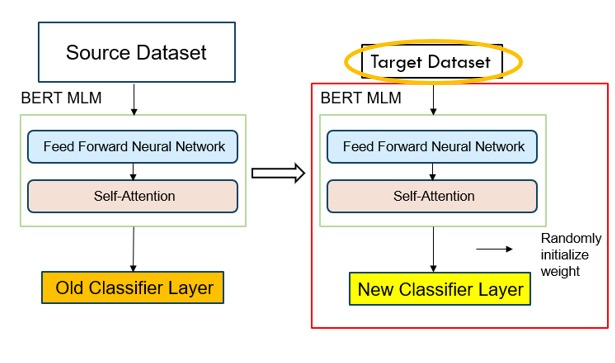

# load dataset

In [2]:
##Train set with 32,218 examples Test set with 5,686 examples 
raw_datasets = load_dataset("AyoubChLin/CNN_News_Articles_2011-2022")

Using custom data configuration AyoubChLin--CNN_News_Articles_2011-2022-93447e1eeb0ebee3
Found cached dataset csv (/root/.cache/huggingface/datasets/AyoubChLin___csv/AyoubChLin--CNN_News_Articles_2011-2022-93447e1eeb0ebee3/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 32218
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5686
    })
})

In [4]:
#filter instance without 'text'
raw_datasets = raw_datasets.filter(lambda x: x["text"] is not None)

Loading cached processed dataset at /root/.cache/huggingface/datasets/AyoubChLin___csv/AyoubChLin--CNN_News_Articles_2011-2022-93447e1eeb0ebee3/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-fd0b887b522d5c9b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/AyoubChLin___csv/AyoubChLin--CNN_News_Articles_2011-2022-93447e1eeb0ebee3/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-ee52c9b1b18c3819.arrow


In [5]:
#calculate unique number of categories in the label
num_category = len(set(raw_datasets['train']['label']))

target

In [6]:
#fit one-hot encoding 
lb = LabelBinarizer()
lb.fit(list(set(raw_datasets['train']['label'])))
lb.classes_

array([0, 1, 2, 3, 4, 5])

In [7]:
#calculate class weights 
class_weights = compute_class_weight('balanced', classes = lb.classes_, y = raw_datasets['train']['label'])
class_weights

array([ 7.33401639, 15.56086957, 11.62012987,  0.3505158 ,  2.53589986,
        0.40550646])

In [8]:
#split training set from raw_datasets into training set and evaluation set
train_val = raw_datasets['train'].train_test_split(test_size=0.1,shuffle=True)

In [9]:
train_test_val_dataset = DatasetDict({
    'train': train_val['train'],
    'test': raw_datasets['test'],
    'val': train_val['test']})

In [10]:
train_test_val_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 28989
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5684
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 3222
    })
})

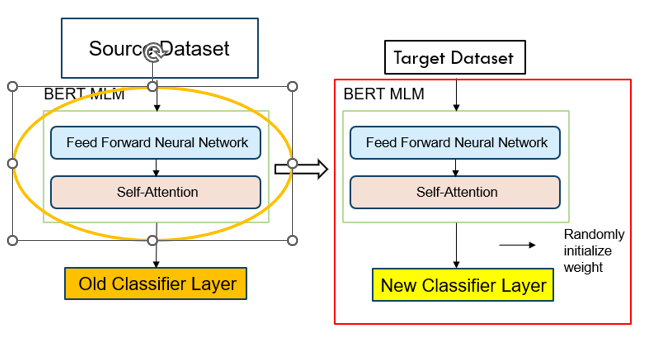

# load pre-trained BERT tokenizer and model

In [11]:
model_checkpoint = 'bert-base-uncased'

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, problem_type= "multi_label_classification", 
                                                           num_labels=num_category)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [14]:
def preprocess_data(examples):
    # convert input text to index, after tokenizer, 'input_ids', 'token_type_ids' and 'attention_mask' will be return
    text = examples["text"]
    encoding = tokenizer(text, padding="max_length", truncation=True)
    
    # convert true labels into one-hot encoding 
    labels = examples['label']
    labels = lb.transform(labels).tolist()
    
    # convert one-hot encoding into the data type hugging face get take
    labels_matrix = np.zeros((len(text), num_category))
    for idx in range(len(text)):
        labels_matrix[idx, :] = labels[idx]
        
    encoding["labels"] = labels_matrix.tolist()
    return encoding

tokenized_datasets = train_test_val_dataset.map(preprocess_data, batched=True, remove_columns=train_test_val_dataset['train'].column_names)

  0%|          | 0/29 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/AyoubChLin___csv/AyoubChLin--CNN_News_Articles_2011-2022-93447e1eeb0ebee3/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-32fc0bd85fa9e5b6.arrow


  0%|          | 0/4 [00:00<?, ?ba/s]

In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 28989
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5684
    })
    val: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3222
    })
})

In [16]:
tokenized_datasets.set_format("torch")
#use GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

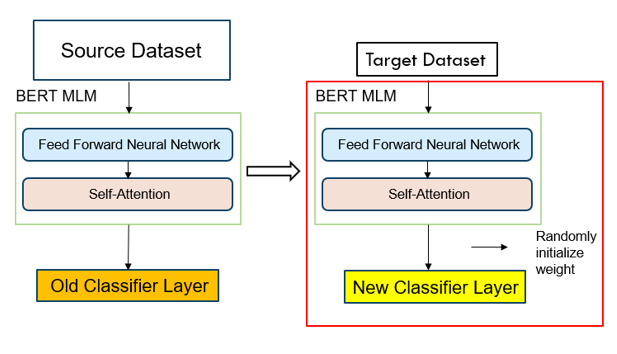

# fine tuning pre-trained BERT for text classification task

In [17]:
#only update weights which the layer name include "classifier"
# for name, param in model.named_parameters():
#     if 'classifier' not in name: # classifier layer
#         param.requires_grad = False

In [18]:
#set up paramaters for training
batch_size = 32
metric_name = "f1"
learning_rate =1e-4
num_epochs =15
f1 = evaluate.load("f1")
acc = evaluate.load("accuracy")

In [19]:
# Function to compute the metric
def compute_metrics(eval_pred):  
    logits, labels = eval_pred
    labels = lb.inverse_transform(labels)
    predictions = np.argmax(logits, axis=1)
    f1_macro_average = f1.compute(predictions=predictions, references=labels, average="macro")
    accuracy = acc.compute(predictions=predictions, references=labels)
    metrics = {'f1': f1_macro_average['f1'],
               'accuracy': accuracy['accuracy']}
    return metrics

In [20]:
#overwrite compute_loss in Trainer API to add class weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")       
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        logits = outputs.get("logits")
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([7.33401639, 15.56086957, 11.62012987,  0.3505158 ,  2.53589986,
        0.40550646]))
        loss_fct.to(device)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [21]:
training_args = TrainingArguments(
    "finetuned-bert-classifier-layer-only",
    evaluation_strategy = "epoch",
    log_level ='info',
    save_strategy = 'epoch',
    save_total_limit =20,  
    learning_rate=learning_rate,    
    num_train_epochs=num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size =batch_size,   
    load_best_model_at_end = True,   
    metric_for_best_model=metric_name,
    weight_decay=0.01,
    optim = "adamw_torch",
    fp16=True,
)

In [22]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [23]:
trainer.train()

***** Running training *****
  Num examples = 28,989
  Num Epochs = 15
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 6,795
  Number of trainable parameters = 109,486,854


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.366492,0.720292,0.885475
2,0.599600,0.430526,0.824114,0.945996
3,0.356800,0.395343,0.808023,0.932340
4,0.264100,1.083347,0.821355,0.953135
5,0.222700,2.030687,0.843495,0.953445
6,0.253900,2.211467,0.836889,0.954376
7,0.136400,2.683832,0.835981,0.955307
8,0.196200,2.567468,0.847124,0.956549
9,0.085900,2.734431,0.850585,0.958101
10,0.068900,3.399648,0.824810,0.955928


***** Running Evaluation *****
  Num examples = 3222
  Batch size = 64
Saving model checkpoint to /project/Meetup_20230717/finetuned-bert/checkpoint-453
Configuration saved in /project/Meetup_20230717/finetuned-bert/checkpoint-453/config.json
Model weights saved in /project/Meetup_20230717/finetuned-bert/checkpoint-453/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3222
  Batch size = 64
Saving model checkpoint to /project/Meetup_20230717/finetuned-bert/checkpoint-906
Configuration saved in /project/Meetup_20230717/finetuned-bert/checkpoint-906/config.json
Model weights saved in /project/Meetup_20230717/finetuned-bert/checkpoint-906/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3222
  Batch size = 64
Saving model checkpoint to /project/Meetup_20230717/finetuned-bert/checkpoint-1359
Configuration saved in /project/Meetup_20230717/finetuned-bert/checkpoint-1359/config.json
Model weights saved in /project/Meetup_20230717/finetuned-bert/checkpoint-135

TrainOutput(global_step=5436, training_loss=0.21006789112722637, metrics={'train_runtime': 6338.442, 'train_samples_per_second': 68.603, 'train_steps_per_second': 1.072, 'total_flos': 9.153120377489818e+16, 'train_loss': 0.21006789112722637, 'epoch': 12.0})

# evaluate on test set

In [24]:
y_logits = trainer.predict(tokenized_datasets["test"])

***** Running Prediction *****
  Num examples = 5684
  Batch size = 64


In [25]:
y_logits

PredictionOutput(predictions=array([[-2.832439 , -3.711131 , -4.0160346, -2.9014497, 14.998144 ,
        -3.908779 ],
       [-4.438882 , -3.8801312, -4.7821183, 14.613967 , -2.856658 ,
        -2.086508 ],
       [-3.5321736, -3.5119371, -4.2920537, -0.4967703, -4.112056 ,
        14.599232 ],
       ...,
       [-4.447869 , -3.8691404, -4.7766933, 14.612562 , -2.8647366,
        -2.0867975],
       [-4.4322853, -3.8846648, -4.78352  , 14.614466 , -2.8582067,
        -2.0852659],
       [-3.5474381, -3.5204825, -4.3281984, -0.3877739, -4.155461 ,
        14.580584 ]], dtype=float32), label_ids=array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32), metrics={'test_loss': 3.2770402431488037, 'test_f1': 0.8558612471964757, 'test_accuracy': 0.9595355383532723, 'test_runtime': 34.3453, 'test_samples_per_second': 165.496, 